# Seq2seq


## Importing library and dataset.

In [1]:
import spacy

In [2]:
from torchtext.datasets import Multi30k
from torchtext.data import Field,BucketIterator

by avoiding reshaping frequently , time could be saved exponentially

In [4]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [3]:
spacy_eng = spacy.load('en_core_web_sm')
spacy_ger = spacy.load('de_core_news_sm')

In [4]:
def tokenize_eng(text):
    return([tok.text for tok in spacy_eng.tokenizer(text)])

In [5]:
def tokenize_ger(text):
    return([tok.text for tok in spacy_ger.tokenizer(text)])

In [6]:
english = Field(sequential=True, use_vocab=True, tokenize=tokenize_eng, lower=True,init_token='<sos>',eos_token='<eos>')
german = Field(sequential=True, use_vocab=True, tokenize=tokenize_ger, lower=True,init_token='<sos>',eos_token='<eos>')

C:\ProgramData\Anaconda3\envs\project2\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [7]:
train_data, validation_data, test_data = Multi30k.splits(exts=('.de','.en'),fields=(german,english))

C:\ProgramData\Anaconda3\envs\project2\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [8]:
english.build_vocab(train_data,max_size=10000,min_freq=2)
german.build_vocab(train_data,max_size=10000,min_freq=2)

#### testing dataset

In [9]:
english.vocab.stoi['the']

7

In [10]:
english.vocab.itos[5]

'.'

In [ ]:
print(len(english.vocab))
print(len(german.vocab))

In [ ]:
len(train_iterator)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

## Model building 

Here , encoder is built with simple pytorch's inbuilt LSTM units. Embeddings are made trainable 

Encoder builds encodings based on german sentence i.e. which has to translated.

In [12]:
class Encoder(nn.Module):
    def __init__(self,vocab_size,embedding,hidden_size,num_layers,batch_size):
        super(Encoder,self).__init__()
        self.vocab_size = vocab_size
        self.embedding = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.lstm = nn.LSTM(embedding,hidden_size,num_layers=num_layers)
        
    def forward(self,x,hidden,cell):
                                                     # x : seqlen, batch
        x = self.embedding(x)                         # output : seqlen, batch, embedding   # input lstm : seqlen,batch,input_size
        x,(hidden,cell) = self.lstm(x,(hidden,cell))     # outputlstm : seq_len, batch, num_directions * hidden_size
        return(x,(hidden,cell))
        
    def initHidden(self,batch_size):
        return(torch.zeros([self.num_layers,batch_size,self.hidden_size]))  #hidden : num_layers * num_directions, batch, hidden_size

Decoder takes last hidden state of encoder and word encodings and generates output sentence. It builds relation between soruce that is german here and target that is english here.

In [13]:
class Decoder(nn.Module):
    def __init__(self,vocab_size,embedding,hidden_size,output_size,num_layers,batch_size=1):
        super(Decoder,self).__init__()
        self.vocab_size = vocab_size
        self.embedding = embedding
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.batch_size = batch_size
        self.lstm = nn.LSTM(embedding,hidden_size,batch_first=True,num_layers=num_layers)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,x,hidden,cell):
        x = self.embedding(x)
        x = x.view(1,x.shape[0],x.shape[1])
        x,(hidden,cell) = self.lstm(x,(hidden,cell))
        x = self.dropout(x)
        x = self.fc(x)
        x = self.relu(x)
        return(x,(hidden,cell))
        
    def initHidden(self,batch_size):
        return(torch.zeros([self.num_layers,batch_size,self.hidden_size]))

In [14]:
class Translate(nn.Module):
    def __init__(self,encoder,decoder,output_size,batch_size):
        super(Translate,self).__init__()
        self.output_size = output_size
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size

    def forward(self,source,target,hidden,cell):    
        
        out,(hidden,cell) = self.encoder(source,hidden,cell)
        
        out = torch.zeros([target.shape[0]-1,self.output_size,source.shape[-1]]).to(device)
    
        for i in range(source.shape[-1]):  #source.shape[0]
            h1 = hidden[:,i,:]
            #print(target[:-1,i].shape)
            c1 = cell[:,i,:]
            #print(h1.reshape(hidden.shape[0],1,hidden.shape[-1]).shape)
            o,(h1,c1) = self.decoder(target[:-1,i],h1.contiguous().view(hidden.shape[0],1,hidden.shape[-1]),c1.contiguous().view(cell.shape[0],1,cell.shape[-1]))
            #print(o.shape)
            out[:,:,i] = o.view(o.shape[1],-1)
            #print(o.shape)
            
            #o[i,:,:],(hidden,cell) = self.decoder(target[i,:],hidden,cell)
        return(out)
            
            

### Some hyperparameters 

In [123]:
english_vocab_size = len(english.vocab)
german_vocab_size = len(german.vocab)
embedding = 60
output_size = english_vocab_size
hidden_size =128
num_layers = 2
batch_size = 128
learning_rate = 0.01
epochs = 5
device='cuda'

In [124]:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits((train_data,validation_data,test_data),
                                                                          batch_size=batch_size,device=device)

In [125]:
encoder = Encoder(german_vocab_size,embedding,hidden_size,num_layers,batch_size)
decoder = Decoder(english_vocab_size,embedding,hidden_size,output_size,num_layers)
model = Translate(encoder,decoder,output_size,batch_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [126]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,043,769 trainable parameters


## Training model. 

In [127]:
loss_lst = []
for epoch in range(epochs):
    epoch_loss = []
    t1 = time.time()
    for batch in train_iterator:
        t11 = time.time()
        batch_loss = []
        source = batch.src
        target = batch.trg
        #print(target.shape)
        hidden = encoder.initHidden(source.shape[1]).to(device)
        cell = encoder.initHidden(source.shape[1]).to(device)
        out = model(source,target,hidden,cell)        
        #print(out.shape)
        #print(target.shape)    
        model.zero_grad()
        optimizer.zero_grad()
            
        #out = out.reshape(-1,german_vocab_size,source.shape[1]).to(device)
        target = target[1:,:].reshape(-1,source.shape[1])
        #print(out.shape)
        #print(target.shape)  
        loss = criterion(out,target)
        batch_loss.append(loss.item())
            
        loss.backward()
        optimizer.step()
        epoch_loss += batch_loss
        t22 = time.time()
        #print("batch loss : {}  ||  time : {}".format(np.mean(batch_loss),t22-t11))
        print(".",end="")
    loss_lst += epoch_loss
    t2 = time.time()
    print()
    print("mean epoch loss : {}  ||  time : {}".format(np.mean(epoch_loss),t2-t1))

...................................................................................................................................................................................................................................
mean epoch loss : 2.389992415117272  ||  time : 328.3025846481323
...................................................................................................................................................................................................................................
mean epoch loss : 1.8194771621720907  ||  time : 415.5052855014801
...................................................................................................................................................................................................................................
mean epoch loss : 1.6633422779091653  ||  time : 332.3217234611511
....................................................................................................................

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

....................

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

....................

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

..............

KeyboardInterrupt: 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

In [128]:
torch.save(model.state_dict(),'translate2_4.pth') 
# translate2_4.pth
#embedding = 50  output_size = german_vocab_size hidden_size =128 num_layers = 2 batch_size = 128 learning_rate = 0.01 epochs = 5 device='cuda'
# time per epoch - 300 , 600, 550, 350, 330 . loss - 2.45 to 1.58 ( may decrease further . may be 2 epochs)

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

expected - 'a man leans against a building near a busy street'
predicted - 'a man is standing in the middle of a large crowd'

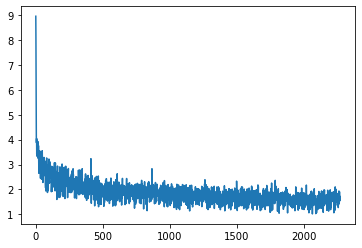

In [81]:
plt.plot(loss_lst)

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

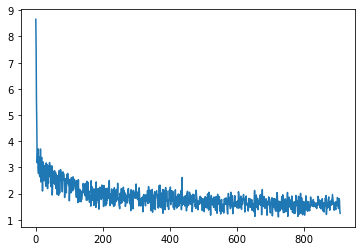

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

In [129]:
plt.plot(loss_lst)

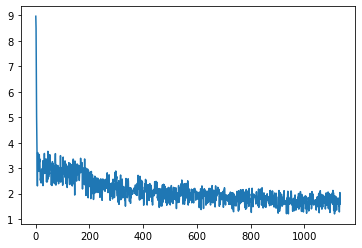

In [64]:
plt.plot(loss_lst)

### If you dont want to train the model , you can load it from here. 

In [85]:
model.load_state_dict(torch.load('translate2_3.pth'))

<All keys matched successfully>

In [18]:
model

Translate(
  (encoder): Encoder(
    (embedding): Embedding(7854, 50)
    (lstm): LSTM(50, 128, num_layers=2)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 50)
    (lstm): LSTM(50, 128, num_layers=2, batch_first=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (fc): Linear(in_features=128, out_features=7854, bias=True)
  )
)

### Testing some random sentences

In [130]:
#sentence = 'ich habe kein interesse am spielen .' # 'i dont have intrest in playing'
#sentence = 'ich bin heute glücklich .'  # 'i am happy today'
#sentence = 'eine frau mochte dieses gebäude .' # 'a woman liked that building'
#sentence = 'eines tages werde ich reich sein .'  # 'one day i will be rich'
sentence = 'ein mann lehnt sich in der nähe einer belebten straße an ein gebäude .'  # 'a man leans against a building near a busy street .'
#sentence = 'wer bin ich .'   # 'who am i'
#sentence = 'ein läufer <unk> sich für ein rennen aus dem <unk> .'  #runner leaving the starting blocks of a race .
sentence = sentence.split()
a = torch.zeros([len(sentence)+2],dtype=torch.long)
a[0] = 2
a[-1]  = 3
#a[1] = 1180
for i in range(0,len(sentence)):
    a[i+1] = german.vocab.stoi[sentence[i]]
    
print(a)
print(sentence)

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host


tensor([  2,   5,  13, 287,  23,   7,  15, 110,  14, 340,  34,  21,   5, 104,
          4,   3])
['ein', 'mann', 'lehnt', 'sich', 'in', 'der', 'nähe', 'einer', 'belebten', 'straße', 'an', 'ein', 'gebäude', '.']


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

In [131]:
hidden = encoder.initHidden(1).to(device)
cell = encoder.initHidden(1).to(device)

out,(hidden,cell) = encoder(a.view(a.shape[0],1).to(device),hidden,cell)
translation = ''
print(out.shape)

word = '<sos>'
word_index = 2
out = torch.tensor([word_index])

while word!='<eos>':
    
    out,(hidden,cell) = decoder(out.to(device),hidden,cell)
    word_index = out.argmax(axis=-1)
    word = english.vocab.itos[word_index]
    out = torch.tensor([word_index])
    if word != '<eos>':
        translation += word + " "
        
print(translation)

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

torch.Size([16, 1, 128])
a man is standing in front of a building with a red toy . 


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE